# Data
- Lead scoring dataset from UCI
    - https://archive.ics.uci.edu/dataset/222/bank+marketing

# Methods
- Feature Engineering
    - One hot encoded categorical features
    - Used SMOTE oversampling to generate more samples for the minority class
    - Features are binned using Chi-square tests
    - Information value (IV) calculated for the bins
    - Features with an IV over 0.1 are selected
- Model
    - Logistic regression trained on the data with the bins used as features
    - Scoring system created with a range of 0 to 100
    - Feature bins are assigned points, where more points are associated with a lead more likely to convert

In [51]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning, BinningProcess, Scorecard
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt
from optbinning.scorecard import plot_auc_roc
import seaborn as sns

In [52]:
df = pd.read_csv("data/raw/bank-additional/bank-additional-full.csv", delimiter=";")

In [53]:
df = df.drop(columns=["duration", "previous", "poutcome"])

In [54]:
cat_cols = ["job", "marital", "education", "default", 
            "housing", "loan", "contact", "month", 
            "day_of_week"]
num_cols = df.columns.difference(cat_cols + ["y"]).tolist()
for c in cat_cols:
    print(f"{c}: {len(df[c].unique())} categories")

job: 12 categories
marital: 4 categories
education: 8 categories
default: 3 categories
housing: 3 categories
loan: 3 categories
contact: 2 categories
month: 10 categories
day_of_week: 5 categories


In [55]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = ohe.fit_transform(df[cat_cols])
ohe_cat_features = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out().tolist())
data = pd.concat([df[num_cols], ohe_cat_features], axis=1)
y = df["y"].map(lambda x: 0 if x == "no" else 1)

In [56]:
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(data, y)

In [57]:
x_sm[x_sm.columns.difference(num_cols)]
for c in cat_cols:
    col_cats = [x for x in list(x_sm.columns) if c in x]
    cats = [x[len(c) + 1:] for x in col_cats]
    argmaxes = x_sm[col_cats].values.argmax(axis=1)
    orig_cat_col = [cats[x] for x in argmaxes]
    x_sm[c] = orig_cat_col
    x_sm = x_sm.drop(columns=col_cats)

In [58]:
x_sm

,age,campaign,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,pdays,job,marital,education,default,housing,loan,contact,month,day_of_week
0,56,1,-36.400000,93.994000,1.1,4.857000,5191.0,999,housemaid,married,basic.4y,no,no,no,telephone,may,mon
1,57,1,-36.400000,93.994000,1.1,4.857000,5191.0,999,services,married,high.school,unknown,no,no,telephone,may,mon
2,37,1,-36.400000,93.994000,1.1,4.857000,5191.0,999,services,married,high.school,no,yes,no,telephone,may,mon
3,40,1,-36.400000,93.994000,1.1,4.857000,5191.0,999,admin.,married,basic.6y,no,no,no,telephone,may,mon
4,56,1,-36.400000,93.994000,1.1,4.857000,5191.0,999,services,married,high.school,no,no,yes,telephone,may,mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73091,32,3,-42.700000,93.918000,1.4,4.960000,5228.1,999,services,married,basic.4y,unknown,no,no,cellular,jul,mon
73092,45,4,-41.800000,94.465000,1.4,4.864277,5228.1,999,technician,married,university.degree,unknown,no,yes,telephone,jun,tue
73093,50,1,-40.800000,92.963000,-2.9,1.262033,5076.2,999,admin.,single,basic.9y,no,unknown,unknown,cellular,jun,wed
73094,25,1,-42.700000,93.918000,1.4,4.962648,5228.1,999,services,single,high.school,unknown,yes,yes,cellular,jul,wed


In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.3)
# ct = ColumnTransformer([
#         ('scaler', StandardScaler(), num_cols)
#     ], remainder='passthrough')

# x_train_scaled = ct.fit_transform(x_train)
# x_test_scaled = ct.transform(x_test)

In [60]:
# x_train_scaled = pd.DataFrame(x_train, columns=x_sm.columns)
# x_test_scaled = pd.DataFrame(x_test, columns=x_sm.columns)

In [67]:
# x = df[df.columns.difference(["y"])]
# y = df["y"].map(lambda x: 0 if x == "no" else 1)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_sm, test_size=0.3)

selection_criteria = {"iv": {"min": 0.1, "max": 2}}
bins = BinningProcess(x_sm.columns.to_list(), selection_criteria=selection_criteria)
model = LogisticRegression(class_weight="balanced")
scorecard = Scorecard(
    binning_process=bins,
    estimator=model,
    scaling_method="min_max",
    scaling_method_params={
        "min": 0,
        "max": 100
    },
    reverse_scorecard=True
)
scorecard.fit(x_train, y_train)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 2,
                                                                    'min': 0.1}},
                                         variable_names=['age', 'campaign',
                                                         'cons.conf.idx',
                                                         'cons.price.idx',
                                                         'emp.var.rate',
                                                         'euribor3m',
                                                         'nr.employed', 'pdays',
                                                         'job', 'marital',
                                                         'education', 'default',
                                                         'housing', 'loan',
                                                         'contact', 'month',
                                                         'day_of_week']),
          estimator=LogisticRegression(class_weight='balanced'),
          reverse_scorecard=True, scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [68]:
pd.set_option('display.max_rows', 500)
scorecard.table()

,Variable,Bin,Points
0,age,"(-inf, 25.50)",6.287331
1,age,"[25.50, 29.50)",4.513039
2,age,"[29.50, 31.50)",3.409249
3,age,"[31.50, 33.50)",3.134796
4,age,"[33.50, 35.50)",2.758314
5,age,"[35.50, 38.50)",2.334063
6,age,"[38.50, 45.50)",1.754211
7,age,"[45.50, 49.50)",1.475547
8,age,"[49.50, 55.50)",2.428380
9,age,"[55.50, 60.50)",3.525581


0.8006800609498828


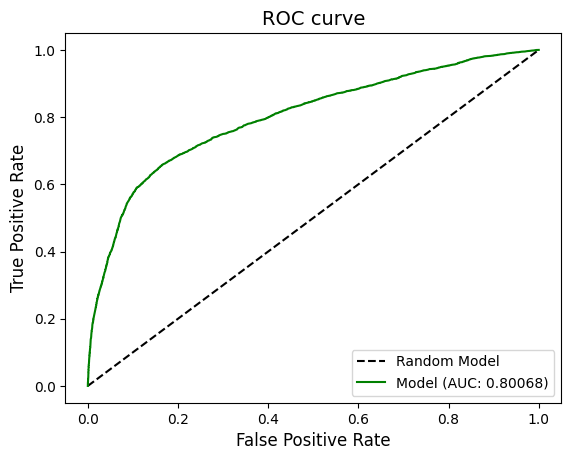

In [69]:
y_pred = scorecard.predict_proba(x_train)[:, 1]
print(roc_auc_score(y_train, y_pred))

plot_auc_roc(y_train, y_pred)

plt.show()

0.7997730249082851


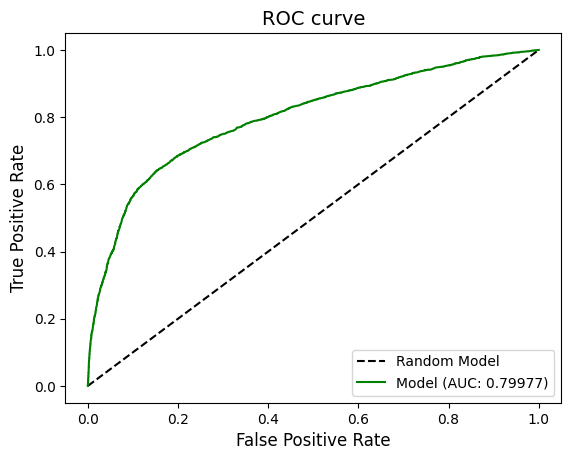

In [70]:
y_pred = scorecard.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

plot_auc_roc(y_test, y_pred)

plt.show()

<Axes: ylabel='Count'>

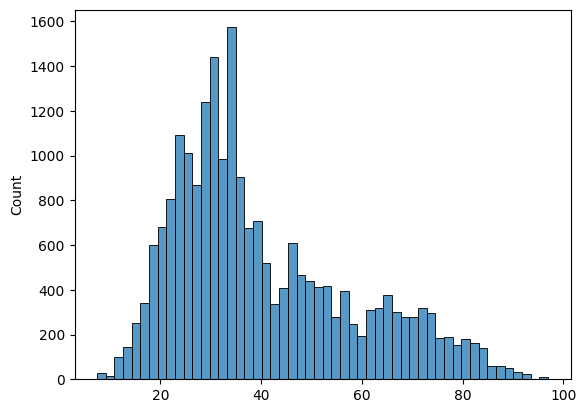

In [71]:
y_score = scorecard.score(x_test)
sns.histplot(y_score)

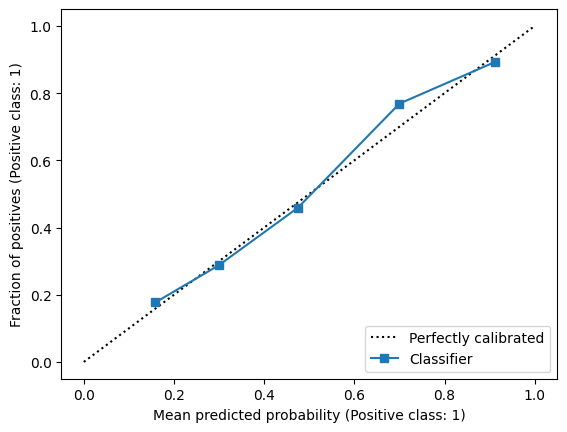

In [72]:
CalibrationDisplay.from_predictions(y_test, scorecard.predict_proba(x_test)[:, -1])